In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
from IPython import display

from dedalus import public as de
from dedalus.extras import flow_tools

import logging
logger = logging.getLogger(__name__)

In [2]:
#Aspect ratio 2
scale_fact = 7
Lx, Ly = (4.*scale_fact, 2.*np.sqrt(3)*scale_fact)
nx, ny = (350, 300)

# Create bases and domain
x_basis = de.Fourier('x', nx, interval=(0, Lx), dealias=3/2)
y_basis = de.Fourier('y', ny, interval=(0, Ly), dealias=3/2)
domain = de.Domain([x_basis, y_basis], grid_dtype=np.float64)

In [3]:
def grow_fun(A,B):
    F = (A.data)*(1-B.data)
    F[A.data < -1e-3] = 0
    return F


def grow_operator(field1,field2):
    return de.operators.GeneralFunction(
        field1.domain,
        layout = 'g',
        func = grow_fun,
        args = (field1,field2,)
    )

de.operators.parseables['grow'] = grow_operator

In [4]:
params = np.load('Parameters.npz')
Diff = params['Diff'].flat[0]
K =  params['K'].flat[0]
g = params['g'].flat[0]

problem = de.IVP(domain, variables=['rho1','rho2','rho3','rho4','rhom'])
problem.parameters['D0'] = Diff
problem.parameters['K'] = K
problem.parameters['g0'] = g


problem.substitutions['rho_b'] = "rho1+rho2+rho3+rho4 + rhom" 
problem.substitutions["Lap(A)"] = "dx(dx(A)) + dy(dy(A))"

problem.substitutions["grow_nl(A,B)"] = "-A*B"
problem.substitutions["grow_l(A)"] = "-A"    

problem.add_equation("dt(rho1)  - D0*Lap(rho1)  = g0*grow(rho1,rho_b) - K*rho1*rho2")
problem.add_equation("dt(rho2)  - D0*Lap(rho2)  = g0*grow(rho2,rho_b) - K*rho2*rho1")
problem.add_equation("dt(rho3)  - D0*Lap(rho3)  = g0*grow(rho3,rho_b) - K*rho3*rho4")
problem.add_equation("dt(rho4)  - D0*Lap(rho4)  = g0*grow(rho4,rho_b) - K*rho4*rho3")

problem.add_equation("dt(rhom)  = 2*K*(rho1*rho2 + rho3*rho4 )")

In [5]:
ts = de.timesteppers.RK443
solver =  problem.build_solver(ts)

In [7]:
x = domain.grid(0)
y = domain.grid(1)
rho1 = solver.state['rho1']
rho2 = solver.state['rho2']
rho3 = solver.state['rho3']
rho4 = solver.state['rho4']

def r(x,y,x0,y0):
    return np.sqrt((x-x0)**2+(y-y0)**2)

def blob_np(x,y,x0,y0,r0,w):
    return 0.5*(1 - np.tanh((r(x,y,x0,y0)-r0)/w))

def blob(x,y,x0,y0,r0,w):
    return blob_np(x,y,x0*scale_fact,y0*scale_fact,r0,w) + blob_np(x,y,x0*scale_fact+Lx,y0*scale_fact,r0,w) + blob_np(x,y,x0*scale_fact,y0*scale_fact+Ly,r0,w) + blob_np(x,y,x0*scale_fact+Lx,y0*scale_fact+Ly,r0,w)


# Triangular lattice points at: 
# (0.5,sqrt(3)/6) + (n,m*sqrt(3))
# (0.5,5*sqrt(3)/6) + (n,m*sqrt(3))
# (1.,sqrt(3)/6 -sqrt(3)/2) + (n,m*sqrt(3))
# (1.,5*sqrt(3)/6-sqrt(3)/2) + (n,m*sqrt(3))

r0 = 0.75
w = 0.22
rho1['g'] = blob(x,y,0.5,np.sqrt(3)/6,r0,w) + blob(x,y,1.5,np.sqrt(3)/6,r0,w) + blob(x,y,2.5,np.sqrt(3)/6,r0,w) +\
            blob(x,y,3.5,np.sqrt(3)/6,r0,w) + blob(x,y,0.0,np.sqrt(3)/3,r0,w) + 0.5*blob(x,y,2.0,np.sqrt(3)/3,r0,w) +\
            blob(x,y,0.5,7*np.sqrt(3)/6,r0,w)  + blob(x,y,1.5,7*np.sqrt(3)/6,r0,w) + blob(x,y,0.0,4*np.sqrt(3)/3,r0,w) +\
            blob(x,y,2.0,4*np.sqrt(3)/3,r0,w)

rho2['g'] = blob(x,y,1.0,np.sqrt(3)/3,r0,w) + blob(x,y,3.0,np.sqrt(3)/3,r0,w) + 0.5*blob(x,y,0.5,5*np.sqrt(3)/6,r0,w) +\
            0.5*blob(x,y,1.5,5*np.sqrt(3)/6,r0,w) + blob(x,y,2.5,7*np.sqrt(3)/6,r0,w)  + blob(x,y,3.5,7*np.sqrt(3)/6,r0,w) +\
            blob(x,y,1.0,4*np.sqrt(3)/3,r0,w) + blob(x,y,3.0,4*np.sqrt(3)/3,r0,w)


rho3['g'] = 0.5*blob(x,y,2.0,np.sqrt(3)/3,r0,w) + blob(x,y,0.0,2*np.sqrt(3)/3,r0,w) + blob(x,y,3.0,2*np.sqrt(3)/3,r0,w) +\
            0.5*blob(x,y,0.5,5*np.sqrt(3)/6,r0,w)


rho4['g'] = blob(x,y,1.0,2*np.sqrt(3)/3,r0,w) + blob(x,y,2.0,2*np.sqrt(3)/3,r0,w)  + 0.5*blob(x,y,1.5,5*np.sqrt(3)/6,r0,w) +\
            blob(x,y,2.5,5*np.sqrt(3)/6,r0,w) + blob(x,y,3.5,5*np.sqrt(3)/6,r0,w) +\
            blob(x,y,0.0,5*np.sqrt(3)/3,r0,w)   + blob(x,y,1.0,5*np.sqrt(3)/3,r0,w) +\
            blob(x,y,2.0,5*np.sqrt(3)/3,r0,w)   + blob(x,y,3.0,5*np.sqrt(3)/3,r0,w)  +\
            blob(x,y,0.5,11*np.sqrt(3)/6,r0,w) + blob(x,y,1.5,11*np.sqrt(3)/6,r0,w) + \
            blob(x,y,2.5,11*np.sqrt(3)/6,r0,w) + blob(x,y,3.5,11*np.sqrt(3)/6,r0,w)
              

In [8]:
solver.stop_sim_time = 90
dt = 0.4*Lx/nx

In [9]:
analysis = solver.evaluator.add_file_handler('sel_lat', sim_dt=1.5, max_writes=500)
analysis.add_task('rho1')
analysis.add_task('rho2')
analysis.add_task('rho3')
analysis.add_task('rho4')
analysis.add_task('rhom')

2021-02-17 10:46:39,530 __main__ 0/1 INFO :: Starting loop


/Users/dominic/miniconda3/envs/dedalus/lib/python3.8/site-packages/dedalus/core/evaluator.py:533: H5pyDeprecationWarning: other_ds.dims.create_scale(ds, name) is deprecated. Use ds.make_scale(name) instead.
  dset.dims.create_scale(scale, sn)
/Users/dominic/miniconda3/envs/dedalus/lib/python3.8/site-packages/dedalus/core/evaluator.py:550: H5pyDeprecationWarning: other_ds.dims.create_scale(ds, name) is deprecated. Use ds.make_scale(name) instead.
  dset.dims.create_scale(scale, lookup)


2021-02-17 10:47:00,022 __main__ 0/1 INFO :: Iteration: 50, Time: 1.600000e+00, dt: 3.200000e-02
2021-02-17 10:47:17,765 __main__ 0/1 INFO :: Iteration: 100, Time: 3.200000e+00, dt: 3.200000e-02
2021-02-17 10:47:38,823 __main__ 0/1 INFO :: Iteration: 150, Time: 4.800000e+00, dt: 3.200000e-02
2021-02-17 10:47:58,893 __main__ 0/1 INFO :: Iteration: 200, Time: 6.400000e+00, dt: 3.200000e-02
2021-02-17 10:48:17,768 __main__ 0/1 INFO :: Iteration: 250, Time: 8.000000e+00, dt: 3.200000e-02
2021-02-17 10:48:35,973 __main__ 0/1 INFO :: Iteration: 300, Time: 9.600000e+00, dt: 3.200000e-02
2021-02-17 10:48:54,843 __main__ 0/1 INFO :: Iteration: 350, Time: 1.120000e+01, dt: 3.200000e-02
2021-02-17 10:49:13,125 __main__ 0/1 INFO :: Iteration: 400, Time: 1.280000e+01, dt: 3.200000e-02
2021-02-17 10:49:32,104 __main__ 0/1 INFO :: Iteration: 450, Time: 1.440000e+01, dt: 3.200000e-02
2021-02-17 10:49:50,363 __main__ 0/1 INFO :: Iteration: 500, Time: 1.600000e+01, dt: 3.200000e-02
2021-02-17 10:50:09,2

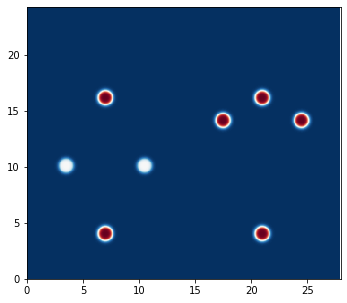

In [11]:
logger.info('Starting loop')
start_time = time.time()
while solver.ok:
    solver.step(dt)
    if solver.iteration % 50 == 0:
        logger.info('Iteration: %i, Time: %e, dt: %e' %(solver.iteration, solver.sim_time, dt))

In [13]:
from dedalus.tools import post
post.merge_process_files("sel_lat", cleanup=True)

2021-02-17 11:03:25,633 post 0/1 INFO :: Merging files from sel_lat


/Users/dominic/miniconda3/envs/dedalus/lib/python3.8/site-packages/dedalus/tools/post.py:230: H5pyDeprecationWarning: other_ds.dims.create_scale(ds, name) is deprecated. Use ds.make_scale(name) instead.
  joint_dset.dims.create_scale(scale, scalename)
